## Notebook to prep the input tracks for generating a locus plot with pyGenomeTrack

- [pyGenomeTracks github](https://pygenometracks.readthedocs.io/en/latest/index.html)
- [pyGenomeTrack docs](https://pygenometracks.readthedocs.io/en/latest/index.html)

For the analysis of PD risk near LRRK2 for cell-type localization and functional fine mapping we will include the following tracks:
- PD risk GWAS signals in the region
- PD risk GWAS signals for variant in LD with risk index variant
- LRRK2 eQTL by cell-type in DLPFC
- cell-type specific ATAC near LRRK2 in DLPFC
- CRISPR-dcas9 guides used to test for CRE's in IPSC derived microglia (iMicroglia)
- CRIRSP-dcas9 guide's effects on LRRK2 expression in iMicroglia
- CRIRSP-dcas9 guide's p-values for effects on LRRK2 expression in iMicroglia

In [1]:
!date

Tue Feb  1 10:35:41 EST 2022


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image

In [3]:
# naming
cohort = 'lrrk2_crispr'

# directories
wrk_dir = '/labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x'
tracks_dir = f'{wrk_dir}/figure_tracks'

# in files
gwas_stats_file = f'{tracks_dir}/pdmeta_sumstats_hg38.h5'
gene_annot_file = f'{tracks_dir}/hg38.ncbiRefSeq.gtf.gz'
ld_variants_file = f'{tracks_dir}/rs76904798_proxySNPs_Dp_JRG.bed'
encode_bb_file = f'{tracks_dir}/encodeCcreCombined.bb'
encode_bed_file = f'{tracks_dir}/encodeCcreCombined.bb'
set4_peak_file = f'{tracks_dir}/Set4_FC_MGL.4.narrowPeak'
set12_peak_file = f'{tracks_dir}/Set12_FC_MGL.4.narrowPeak'
crispr_guides_files = f'{tracks_dir}/cellecta_sgRNA_library_coord.bed'
crispr_data_file = f'{wrk_dir}/{cohort}.crispr_dcas.LRRK2.data.csv'
crispr_target_results = f'{wrk_dir}/{cohort}.crispr_dcas.LRRK2.targets.results.csv'
crispr_guide_results = f'{wrk_dir}/{cohort}.crispr_dcas.LRRK2.guides.results.csv'

# out files
config_file = f'{tracks_dir}/{cohort}.ini'
gwas_bedgraph_file = f'{tracks_dir}/gwas.bedgraph'
set4_bg_file = f'{tracks_dir}/Set4_FC_MGL.bedgraph'
set12_bg_file = f'{tracks_dir}/Set12_FC_MGL.bedgraph'
gwas_ld_bedgraph_file = f'{tracks_dir}/gwas.ld.bedgraph'
encode_bed_file = f'{tracks_dir}/encodeCcreCombined.bed'
figure_file = f'{tracks_dir}/{cohort}.png'
crispr_target_bedgraph = f'{tracks_dir}/{cohort}.targets.bedgraph'
crispr_target_coef_bedgraph = f'{tracks_dir}/{cohort}.targets.effect.bedgraph'
crispr_target_p_bedgraph = f'{tracks_dir}/{cohort}.targets.pvalue.bedgraph'
crispr_guides_bedgraph = f'{tracks_dir}/{cohort}.guides.bedgraph'
crispr_guides_coef_bedgraph = f'{tracks_dir}/{cohort}.guides.effect.bedgraph'
crispr_guides_p_bedgraph = f'{tracks_dir}/{cohort}.guides.pvalue.bedgraph'

# variables
chrom = 12
start_bp = 40140000
stop_bp = 40230000
debug = True
config_content = ''
nl = '\n'

#### utility functions

In [4]:
# run command line procsss with bash majic
# make this a small function so it can be target function for parallelization if needed
def run_bash_cmd(this_cmd: str, verbose: bool=False):
    if verbose:
        print(this_cmd)
    !{this_cmd}

### GWAS track

#### load the summary stats

In [5]:
%%time
gwas_df = pd.read_hdf(gwas_stats_file)
print(gwas_df.shape)
if debug:
    display(gwas_df.sample(5))

(7769022, 11)


,SNP,A1,A2,freq,b,se,p,N,chr,position,id
3142322,rs551237777,A,G,0.0130,-0.1024,0.0848,0.22730,482730,chr1,247450145,rs551237777
5223296,rs6822937,C,G,0.8546,0.0238,0.0144,0.09813,1460059,chr4,181332112,rs6822937
4517658,rs12495436,A,C,0.1682,0.0131,0.0134,0.32950,1460059,chr3,13676151,rs12495436
1555424,rs1959518,A,G,0.5730,-0.0033,0.0097,0.73570,1474097,chr14,51886194,rs1959518
3350531,rs2391769,A,G,0.3464,0.0144,0.0099,0.14820,1474097,chr1,96513405,rs2391769


CPU times: user 21.3 s, sys: 1.14 s, total: 22.4 s
Wall time: 22.4 s


#### convert gwas df to bedgraph

In [6]:
gwas_df = gwas_df.loc[(gwas_df.chr == f'chr{chrom}') & 
                      (gwas_df.position >= start_bp) & 
                      (gwas_df.position <= stop_bp)]
gwas_bed = gwas_df[['chr', 'position', 'id']].copy()
gwas_bed['end'] = gwas_bed['position'] + 1
gwas_bed.chr = gwas_bed.chr.str.replace('chr', '')
gwas_bed['signal'] = -np.log10(gwas_df.p)
gwas_bed = gwas_bed[['chr', 'position', 'end', 'signal', 'id']]
print(gwas_bed.shape)
if debug:
    display(gwas_bed.sample(5))

(363, 5)


,chr,position,end,signal,id
975925,12,40158077,40158078,2.195656,rs74869552
975962,12,40163993,40163994,1.934420,rs2708476
976093,12,40191169,40191170,5.804100,rs117549742
976007,12,40170420,40170421,4.654430,rs117916891
976166,12,40212205,40212206,16.979225,rs2263420


#### save the gwas bedgraph

In [7]:
gwas_bed.to_csv(gwas_bedgraph_file, index=False, header=False, sep='\t')

#### format gwas track config string

In [8]:
this_content = f'[GWAS]{nl}\
title = PD GWAS{nl}\
file = {gwas_bedgraph_file}{nl}\
file_type = bedgraph{nl}\
type = points:6{nl}\
color = blue{nl}\
use_middle = true{nl}\
min_value = 0{nl}\
height = 5{nl}{nl}\
[hlines ovelayed]{nl}\
color = grey{nl}\
line_width = 1{nl}\
line_style = dotted{nl}\
y_values = 7.3{nl}\
file_type = hlines{nl}\
overlay_previous = share-y{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[GWAS]
title = PD GWAS
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/gwas.bedgraph
file_type = bedgraph
type = points:6
color = blue
use_middle = true
min_value = 0
height = 5

[hlines ovelayed]
color = grey
line_width = 1
line_style = dotted
y_values = 7.3
file_type = hlines
overlay_previous = share-y




#### load variants in high LD with risk index variant

In [9]:
ld_df = pd.read_csv(ld_variants_file, header=None, sep='\s+')
ld_df.columns = ['chrom', 'start', 'stop', 'id']
print(ld_df.shape)
if debug:
    display(ld_df.head())

(33, 4)


,chrom,start,stop,id
0,chr12,40009630,40009630,rs12368785
1,chr12,40081309,40081309,rs144251162
2,chr12,40117094,40117094,rs113039723
3,chr12,40139549,40139549,rs2638224
4,chr12,40147395,40147395,rs2638269


#### subset gwas bed to create bedgraph for LD variats to overlay

In [10]:
ld_gwas_bed = gwas_bed.loc[gwas_bed.id.isin(ld_df.id)]
print(ld_gwas_bed.shape)
if debug:
    display(ld_gwas_bed.head())

(22, 5)


,chr,position,end,signal,id
975869,12,40147395,40147396,4.897223,rs2638269
975968,12,40164911,40164912,10.905878,rs79179868
976050,12,40178422,40178423,5.806041,rs2638244
976105,12,40194013,40194014,5.086981,rs11175546
976107,12,40194606,40194607,6.047983,rs10878208


#### save the gwas ld bedgraph

In [11]:
ld_gwas_bed.to_csv(gwas_ld_bedgraph_file, index=False, header=False, sep='\t')

#### format gwas LD track config string

In [12]:
this_content = f'[GWAS]{nl}\
file = {gwas_ld_bedgraph_file}{nl}\
file_type = bedgraph{nl}\
type = points:10{nl}\
color = red{nl}\
use_middle = true{nl}\
min_value = 0{nl}\
height = 5{nl}\
overlay_previous = share-y{nl}\
[x-axis]{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[GWAS]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/gwas.ld.bedgraph
file_type = bedgraph
type = points:10
color = red
use_middle = true
min_value = 0
height = 5
overlay_previous = share-y
[x-axis]




### genes track

#### format the genes annot config string

In [13]:
this_content = f'[spacer]{nl}{nl}\
[genes]{nl}\
title = LRRK2{nl}\
file = {gene_annot_file}{nl}\
height = 2{nl}\
merge_transcripts = true{nl}\
prefered_name = gene_name{nl}\
fontsize = 12{nl}\
style = UCSC{nl}\
max_labels = 200{nl}\
file_type = gtf{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[genes]
title = LRRK2
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/hg38.ncbiRefSeq.gtf.gz
height = 2
merge_transcripts = true
prefered_name = gene_name
fontsize = 12
style = UCSC
max_labels = 200
file_type = gtf




### load CRISPR info

In [14]:
quants_df = pd.read_csv(crispr_data_file)
print(quants_df.shape)
if debug:
    display(quants_df.sample(5))
    display(quants_df.target.value_counts())

guides_df = pd.read_csv(crispr_guides_files, header=None, sep='\s+')
guides_df.columns = ['chrom', 'start', 'stop', 'desc']
# parse info out of description columns
names = guides_df.desc.str.split('|', expand=True)
names['guide'] = names[2].str.replace('sg_peak_', 'sgPeak').str.replace('sg_rs', 'sgrs')
names['target'] = names[3].str.replace('peak_', 'sgPeak').str.replace('rs', 'sgrs')
guides_df['guide'] = names['guide']
guides_df['target'] = names['target']
# compute the target interval from the guide positions
target_starts = guides_df.groupby('target').min(['start', 'stop'])
target_stops = guides_df.groupby('target').max(['start', 'stop'])
guides_df['target_start'] = 0
for index, row in target_starts.iterrows():
    guides_df.loc[guides_df.target == index, 'target_start'] = row.min()
guides_df['target_stop'] = 0
for index, row in target_stops.iterrows():
    guides_df.loc[guides_df.target == index, 'target_stop'] = row.max()  
print(guides_df.shape)
if debug:
    display(guides_df.sample(5))
    display(guides_df.target.value_counts())

(76686, 10)


,Unnamed: 0,LRRK2,adj_LRRK2,targeted,expr_name,num_features,feature_call,target,total_counts,pct_counts_mt
75267,TTGATGGGTATCACCA-1,0.0,0.069797,0,ci3-gex-fb,3.0,sgPeak38437_10|sgPeak38441_111|sgPeak38441_233,mixed,5471.0,5.995247
11207,ATCCGTCGTTCCGCTT-1,0.0,0.065668,1,ci2-gex-fb,1.0,sgPeak38441_88,sgPeak38441,8006.0,6.794904
27364,AAAGGTAAGTGGCCTC-1,0.0,0.087762,0,ci3-gex-fb,10.0,sgNT_22|sgPeak38433_41|sgPeak38437_26|sgPeak38...,mixed,8927.0,6.082670
40730,CAGATACAGTTTCGAC-1,0.0,0.073180,0,ci3-gex-fb,4.0,sgPeak38440_11|sgPeak38441_24|sgPeak38441_196|...,mixed,10049.0,4.408399
50843,CTTTCAATCGAATCCA-1,0.0,0.065718,0,ci3-gex-fb,2.0,sgPeak38437_20|sgPeak38441_67,mixed,10227.0,4.849907


mixed          44517
sgPeak38441    25864
sgNT            2122
sgPeak38433     1634
sgPeak38437     1284
sgPeak38440      764
sgPeak38439      406
sgrs7294619       95
Name: target, dtype: int64

(483, 8)


,chrom,start,stop,desc,guide,target,target_start,target_stop
304,chr12,40225028,40225046,4|CRi|sg_peak_38441_189|peak_38441,sgPeak38441_189,sgPeak38441,40224067,40227099
425,chr12,40226256,40226238,4|CRi|sg_peak_38441_310|peak_38441,sgPeak38441_310,sgPeak38441,40224067,40227099
38,chr12,40147646,40147664,4|CRi|sg_peak_38433_039|peak_38433,sgPeak38433_039,sgPeak38433,40147169,40147687
31,chr12,40147601,40147619,4|CRi|sg_peak_38433_032|peak_38433,sgPeak38433_032,sgPeak38433,40147169,40147687
361,chr12,40225403,40225385,4|CRi|sg_peak_38441_246|peak_38441,sgPeak38441_246,sgPeak38441,40224067,40227099


sgPeak38441    367
sgPeak38433     46
sgPeak38437     34
sgPeak38440     22
sgPeak38439     11
sgrs7294619      3
Name: target, dtype: int64

### CRISPR targets tracks

#### create track for mean expression by target

In [15]:
target_means = quants_df.groupby('target')['adj_LRRK2'].mean()
target_pos = guides_df[['chrom', 'target_start', 'target_stop', 'target']].copy()
target_pos.drop_duplicates(keep='first', inplace=True)
target_bed = pd.merge(target_means.to_frame(), target_pos, how='left', 
                      left_index=True, right_on='target')
# get mean value for the CRISPR non-targeted guides
nt_mean_value = target_bed.loc[target_bed.target == 'sgNT']['adj_LRRK2'].mean()  
# drop items with data; ie for CRISPR non-targeted, mixed
target_bed = target_bed.loc[target_bed.chrom.notna()]
target_bed = target_bed[['chrom', 'target_start', 'target_stop', 'adj_LRRK2', 'target']]
# for bedgrap insure position aren't floats
target_bed['target_start'] = target_bed['target_start'].astype('int64')
target_bed['target_stop'] = target_bed['target_stop'].astype('int64')
print(target_bed.shape)
if debug:
    display(target_bed)
    print(f'non-targeted mean = {nt_mean_value}')    

(6, 5)


,chrom,target_start,target_stop,adj_LRRK2,target
0.0,chr12,40147169,40147687,0.153803,sgPeak38433
46.0,chr12,40208613,40209118,0.130604,sgPeak38437
80.0,chr12,40217012,40217148,0.160407,sgPeak38439
94.0,chr12,40223615,40223902,0.152004,sgPeak38440
116.0,chr12,40224067,40227099,0.116367,sgPeak38441
91.0,chr12,40223367,40223395,0.171057,sgrs7294619


non-targeted mean = 0.14974924142282303


#### save the bedgraph

In [16]:
target_bed.to_csv(crispr_target_bedgraph, index=False, header=False, sep='\t')

#### format track config string

In [17]:
this_content = f'[spacer]{nl}{nl}\
[LRRK2 expression by target]{nl}\
file = {crispr_target_bedgraph}{nl}\
title = Expression by Target{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
min_value = 0{nl}\
height = 5{nl}\
[hlines ovelayed]{nl}\
color = gray{nl}\
line_width = 1{nl}\
line_style = dotted{nl}\
y_values = {nt_mean_value}{nl}\
file_type = hlines{nl}\
overlay_previous = share-y{nl}\
[x-axis]{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[LRRK2 expression by target]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.targets.bedgraph
title = Expression by Target
file_type = bedgraph
color = black
min_value = 0
height = 5
[hlines ovelayed]
color = gray
line_width = 1
line_style = dotted
y_values = 0.14974924142282303
file_type = hlines
overlay_previous = share-y
[x-axis]




#### load the CRISPR target results

In [18]:
target_results = pd.read_csv(crispr_target_results)
print(target_results.shape)
if debug:
    display(target_results)

(6, 9)


,dep,indep,intercept,coef,stderr,z,p-value,t_cnt,nt_cnt
0,LRRK2,sgPeak38433,-2.807267,0.039107,0.069968,0.558920,5.762163e-01,1634,2122
1,LRRK2,sgPeak38437,-3.084062,-0.253706,0.081983,-3.094593,1.970828e-03,1284,2122
2,LRRK2,sgPeak38439,-2.858136,0.114472,0.113538,1.008225,3.133465e-01,406,2122
3,LRRK2,sgrs7294619,-2.873822,0.215134,0.214932,1.000939,3.168564e-01,95,2122
4,LRRK2,sgPeak38440,-2.823078,0.030711,0.090247,0.340300,7.336304e-01,764,2122
5,LRRK2,sgPeak38441,-2.612449,-0.367067,0.060409,-6.076408,1.229047e-09,25864,2122


#### merge target results with target positions

In [19]:
target_pos = guides_df[['chrom', 'target_start', 'target_stop', 'target']].copy()
target_pos.drop_duplicates(keep='first', inplace=True)
target_bed = pd.merge(target_results, target_pos, how='left', 
                      left_on='indep', right_on='target')

target_bed['signal'] = -np.log10(target_bed['p-value'])
print(target_bed.shape)
if debug:
    display(target_bed)

(6, 14)


,dep,indep,intercept,coef,stderr,z,p-value,t_cnt,nt_cnt,chrom,target_start,target_stop,target,signal
0,LRRK2,sgPeak38433,-2.807267,0.039107,0.069968,0.558920,5.762163e-01,1634,2122,chr12,40147169,40147687,sgPeak38433,0.239414
1,LRRK2,sgPeak38437,-3.084062,-0.253706,0.081983,-3.094593,1.970828e-03,1284,2122,chr12,40208613,40209118,sgPeak38437,2.705351
2,LRRK2,sgPeak38439,-2.858136,0.114472,0.113538,1.008225,3.133465e-01,406,2122,chr12,40217012,40217148,sgPeak38439,0.503975
3,LRRK2,sgrs7294619,-2.873822,0.215134,0.214932,1.000939,3.168564e-01,95,2122,chr12,40223367,40223395,sgrs7294619,0.499138
4,LRRK2,sgPeak38440,-2.823078,0.030711,0.090247,0.340300,7.336304e-01,764,2122,chr12,40223615,40223902,sgPeak38440,0.134523
5,LRRK2,sgPeak38441,-2.612449,-0.367067,0.060409,-6.076408,1.229047e-09,25864,2122,chr12,40224067,40227099,sgPeak38441,8.910432


#### save the CRISPR target results bedgraphs

In [20]:
coef_bed = target_bed[['chrom', 'target_start', 'target_stop', 'z', 'target']]
coef_bed.to_csv(crispr_target_coef_bedgraph, index=False, header=False, sep='\t')
pvalue_bed = target_bed[['chrom', 'target_start', 'target_stop', 'signal', 'target']]
pvalue_bed.to_csv(crispr_target_p_bedgraph, index=False, header=False, sep='\t')

#### format track config string

In [21]:
this_content = f'[spacer]{nl}{nl}\
[target effect on LRRK2]{nl}\
file = {crispr_target_coef_bedgraph}{nl}\
title = target effect on LRRK2{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
height = 5{nl}\
[hlines ovelayed]{nl}\
color = black{nl}\
line_width = 1{nl}\
line_style = dotted{nl}\
y_values = 0{nl}\
file_type = hlines{nl}\
overlay_previous = share-y{nl}\
[spacer]{nl}{nl}\
[target pvalue]{nl}\
file = {crispr_target_p_bedgraph}{nl}\
title = target pvalue on LRRK2{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
min_value = 0{nl}\
height = 5{nl}\
[x-axis]{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[target effect on LRRK2]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.targets.effect.bedgraph
title = target effect on LRRK2
file_type = bedgraph
color = black
height = 5
[hlines ovelayed]
color = black
line_width = 1
line_style = dotted
y_values = 0
file_type = hlines
overlay_previous = share-y
[spacer]

[target pvalue]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.targets.pvalue.bedgraph
title = target pvalue on LRRK2
file_type = bedgraph
color = black
min_value = 0
height = 5
[x-axis]




### CRISPR guides track

In [22]:
guide_results = pd.read_csv(crispr_guide_results)
print(guide_results.shape)
if debug:
    display(guide_results.head())

(483, 10)


,dep,indep,intercept,coef,stderr,z,p-value,t_cnt,nt_cnt,fdr_bh
0,LRRK2,sgPeak38441_95,-2.912136,0.032635,0.421406,0.077443,0.938271,26,1938,0.972500
1,LRRK2,sgPeak38440_11,-2.895616,-0.112319,0.430248,-0.261056,0.794049,26,1938,0.935428
2,LRRK2,sgPeak38441_320,-2.950218,-1.231270,0.529881,-2.323673,0.020143,27,1938,0.202689
3,LRRK2,sgPeak38441_195,-2.890903,-1.298720,0.413088,-3.143933,0.001667,47,1938,0.032205
4,LRRK2,sgPeak38433_26,-2.878118,0.658402,0.374081,1.760053,0.078399,25,1938,0.402837


#### create track for mean expression by guide

In [23]:
guide_means = quants_df.loc[quants_df.num_features == 1].groupby('feature_call').adj_LRRK2.mean()
guides_pos = guides_df[['chrom', 'start', 'stop', 'guide']].copy()
guides_pos.drop_duplicates(keep='first', inplace=True)
# guide results are little inconsisten in naming no '_00' but should be
# easier to keep messy and fix postions on the copy before merge
guides_pos['guide'] = guides_pos['guide'].str.replace('_00', '_0')
# seems like pyGenome tracks can't handle bedgraph pos's in both directions
for index, row in guides_pos.iterrows():
    if row.start > row.stop:
        guides_pos.at[index, 'start'] = row.stop
        guides_pos.at[index, 'stop'] = row.start
guides_bed = pd.merge(guide_means.to_frame(), guides_pos, how='left', 
                      left_index=True, right_on='guide')
# drop items with data; ie for CRISPR non-targeted, mixed
guides_bed = guides_bed.loc[guides_bed.chrom.notna()]
guides_bed = guides_bed[['chrom', 'start', 'stop', 'adj_LRRK2', 'guide']]
# for bedgrap insure position aren't floats
guides_bed['start'] = guides_bed['start'].astype('int64')
guides_bed['stop'] = guides_bed['stop'].astype('int64')
print(guides_bed.shape)
if debug:
    display(guides_bed.sample(5))
    print(f'non-targeted mean = {nt_mean_value}')    

(316, 5)


,chrom,start,stop,adj_LRRK2,guide
475.0,chr12,40226956,40226974,0.099645,sgPeak38441_360
374.0,chr12,40225537,40225555,0.081958,sgPeak38441_259
264.0,chr12,40224873,40224891,0.097791,sgPeak38441_149
88.0,chr12,40217091,40217109,0.160548,sgPeak38439_09
330.0,chr12,40225132,40225150,0.073492,sgPeak38441_215


non-targeted mean = 0.14974924142282303


#### save the bedgraph

In [24]:
guides_bed.to_csv(crispr_guides_bedgraph, index=False, header=False, sep='\t')

#### format track config string

In [25]:
this_content = f'[spacer]{nl}{nl}\
[LRRK2 expression by guide]{nl}\
file = {crispr_guides_bedgraph}{nl}\
title = Expression by Guide{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
min_value = 0{nl}\
height = 5{nl}\
[hlines ovelayed]{nl}\
color = gray{nl}\
line_width = 1{nl}\
line_style = dotted{nl}\
y_values = {nt_mean_value}{nl}\
file_type = hlines{nl}\
overlay_previous = share-y{nl}\
[x-axis]{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[LRRK2 expression by guide]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.guides.bedgraph
title = Expression by Guide
file_type = bedgraph
color = black
min_value = 0
height = 5
[hlines ovelayed]
color = gray
line_width = 1
line_style = dotted
y_values = 0.14974924142282303
file_type = hlines
overlay_previous = share-y
[x-axis]




#### merge guide results with guide positions

In [26]:
# guide results are little inconsisten in naming no '_00' but should be
# easier to keep messy and fix postions on the copy before merge
guides_pos['guide'] = guides_pos['guide'].str.replace('_00', '_').str.replace('_0', '_')
guide_results['indep'] = guide_results['indep'].str.replace('_00', '_').str.replace('_0', '_')
guides_bed = pd.merge(guide_results, guides_pos, how='left', 
                      left_on='indep', right_on='guide')

guides_bed['signal'] = -np.log10(guides_bed['p-value'])
print(guides_bed.shape)
if debug:
    display(guides_bed.sample(5))

(483, 15)


,dep,indep,intercept,coef,stderr,z,p-value,t_cnt,nt_cnt,fdr_bh,chrom,start,stop,guide,signal
239,LRRK2,sgPeak38441_84,-2.848990,-0.512668,0.510146,-1.004944,0.314924,22,1938,0.725615,chr12,40224635,40224653,sgPeak38441_84,0.501795
159,LRRK2,sgPeak38437_8,-2.964676,0.477140,0.328588,1.452092,0.146476,36,1938,0.527970,chr12,40208657,40208675,sgPeak38437_8,0.834233
206,LRRK2,sgPeak38441_87,-2.935089,-0.676330,0.391601,-1.727088,0.084152,40,1938,0.406454,chr12,40224639,40224657,sgPeak38441_87,1.074936
88,LRRK2,sgPeak38441_187,-2.899938,-0.686619,0.388170,-1.768859,0.076917,41,1938,0.402837,chr12,40225004,40225022,sgPeak38441_187,1.113975
266,LRRK2,sgPeak38441_208,-2.921407,-0.037805,0.609688,-0.062007,0.950557,13,1938,0.972704,chr12,40225091,40225109,sgPeak38441_208,0.022022


#### save the CRISPR target results bedgraphs

In [27]:
coef_bed = guides_bed[['chrom', 'start', 'stop', 'z', 'guide']]
coef_bed.to_csv(crispr_guides_coef_bedgraph, index=False, header=False, sep='\t')
pvalue_bed = guides_bed[['chrom', 'start', 'stop', 'signal', 'guide']]
pvalue_bed.to_csv(crispr_guides_p_bedgraph, index=False, header=False, sep='\t')

#### format track config string

In [28]:
this_content = f'[spacer]{nl}{nl}\
[guide effect on LRRK2]{nl}\
file = {crispr_guides_coef_bedgraph}{nl}\
title = guide effect on LRRK2{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
height = 5{nl}\
[hlines ovelayed]{nl}\
color = black{nl}\
line_width = 1{nl}\
line_style = dotted{nl}\
y_values = 0{nl}\
file_type = hlines{nl}\
overlay_previous = share-y{nl}\
[spacer]{nl}{nl}\
[target pvalue]{nl}\
file = {crispr_guides_p_bedgraph}{nl}\
title = giude pvalue on LRRK2{nl}\
file_type = bedgraph{nl}\
color = black{nl}\
min_value = 0{nl}\
height = 5{nl}\
[x-axis]{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[guide effect on LRRK2]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.guides.effect.bedgraph
title = guide effect on LRRK2
file_type = bedgraph
color = black
height = 5
[hlines ovelayed]
color = black
line_width = 1
line_style = dotted
y_values = 0
file_type = hlines
overlay_previous = share-y
[spacer]

[target pvalue]
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.guides.pvalue.bedgraph
title = giude pvalue on LRRK2
file_type = bedgraph
color = black
min_value = 0
height = 5
[x-axis]




### FC MGL peaks

In [29]:
this_content = f'[spacer]{nl}{nl}\
[MGL set4]{nl}\
title = Set4_FC_MGL{nl}\
file = {set4_peak_file}{nl}\
height = 3{nl}\
show_labels = false{nl}\
use_summit = false{nl}\
type = peak{nl}\
width_adjust = 0.2{nl}\
file_type = narrow_peak{nl}{nl}\
[spacer]{nl}{nl}\
[MGL set12]{nl}\
title = Set12_FC_MGL{nl}\
file = {set12_peak_file}{nl}\
height = 3{nl}\
show_labels = false{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[MGL set4]
title = Set4_FC_MGL
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/Set4_FC_MGL.4.narrowPeak
height = 3
show_labels = false
use_summit = false
type = peak
width_adjust = 0.2
file_type = narrow_peak

[spacer]

[MGL set12]
title = Set12_FC_MGL
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/Set12_FC_MGL.4.narrowPeak
height = 3
show_labels = false




#### convert the peaks from narrow peak to bedgraph, so more granualar than smoothed

In [30]:
# def cnvrt_narrow_to_bedgraph(in_file, out_file, 
#                              verbose: bool=True) -> [pd.DataFrame, pd.DataFrame]:
#     peaks_df = pd.read_csv(in_file, header=None, sep='\s+')
#     bg_df = peaks_df[[0, 1, 2, 6, 3]]
#     bg_df.to_csv(out_file, index=False, header=False, sep='\t')
#     if verbose:
#         print(peaks_df.shape)
#         display(peaks_df.head())
#         print(bg_df.shape)
#         display(bg_df.head())
#     return bg_df, peaks_df
  
# peaks_df, bg_df = cnvrt_narrow_to_bedgraph(set4_peak_file, set4_bg_file, 
#                                            verbose=debug)
# peaks_df, bg_df = cnvrt_narrow_to_bedgraph(set12_peak_file, set12_bg_file, 
#                                            verbose=debug)

In [31]:
# this_content = f'[spacer]{nl}{nl}\
# [MGL set4]{nl}\
# title = Set4_FC_MGL{nl}\
# file = {set4_bg_file}{nl}\
# height = 5{nl}\
# file_type = bedgraph{nl}{nl}\
# [spacer]{nl}{nl}\
# [MGL set12]{nl}\
# title = Set12_FC_MGL{nl}\
# file = {set12_bg_file}{nl}\
# height = 5{nl}\
# file_type = bedgraph{nl}{nl}'

# config_content = config_content + this_content

# if debug:
#     print(this_content)

#### create the Encode CRE bed

In [32]:
this_cmd = f'bigBedToBed {encode_bb_file} -chrom=chr{chrom} -start={start_bp} \
-end={stop_bp} {encode_bed_file}'
run_bash_cmd(this_cmd, debug)

bigBedToBed /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/encodeCcreCombined.bb -chrom=chr12 -start=40140000 -end=40230000 /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/encodeCcreCombined.bed


#### add encode track to config

In [33]:
this_content = f'[spacer]{nl}{nl}\
[CRE]{nl}\
title = ENCODE CRE{nl}\
file = {encode_bed_file}{nl}\
height = 3{nl}\
fontsize = 8{nl}\
file_type = bed{nl}\
color = Reds{nl}\
display = collapsed{nl}\
labels = false{nl}\
border_color = black{nl}{nl}'

config_content = config_content + this_content

if debug:
    print(this_content)

[spacer]

[CRE]
title = ENCODE CRE
file = /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/encodeCcreCombined.bed
height = 3
fontsize = 8
file_type = bed
color = Reds
display = collapsed
labels = false
border_color = black




### save the config file content

In [34]:
with open(config_file, 'w') as f:
    f.write(config_content)

### generate the figure

In [35]:
this_cmd = f'pyGenomeTracks --tracks {config_file} \
--region chr{chrom}:{start_bp}-{stop_bp} --dpi 100 \
--title "hello {cohort}" \
--outFileName {figure_file}'
run_bash_cmd(this_cmd, debug)

pyGenomeTracks --tracks /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.ini --region chr12:40140000-40230000 --dpi 100 --title "hello lrrk2_crispr" --outFileName /labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x/figure_tracks/lrrk2_crispr.png
INFO:pygenometracks.tracksClass:initialize 1. [GWAS]
100%|██████████████████████████████████████| 363/363 [00:00<00:00, 41969.63it/s]
INFO:pygenometracks.tracksClass:initialize 2. [hlines ovelayed]
INFO:pygenometracks.tracksClass:initialize 3. [GWAS]
100%|████████████████████████████████████████| 22/22 [00:00<00:00, 42096.12it/s]
INFO:pygenometracks.tracksClass:initialize 4. [x-axis]
INFO:pygenometracks.tracksClass:initialize 5. [spacer]
INFO:pygenometracks.tracksClass:initialize 6. [genes]
100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 238.01it/s]
INFO:pygenometracks.tracksClass:initialize 7. [spacer]
INFO:pygenometracks.tracksClas

#### view the generated figure

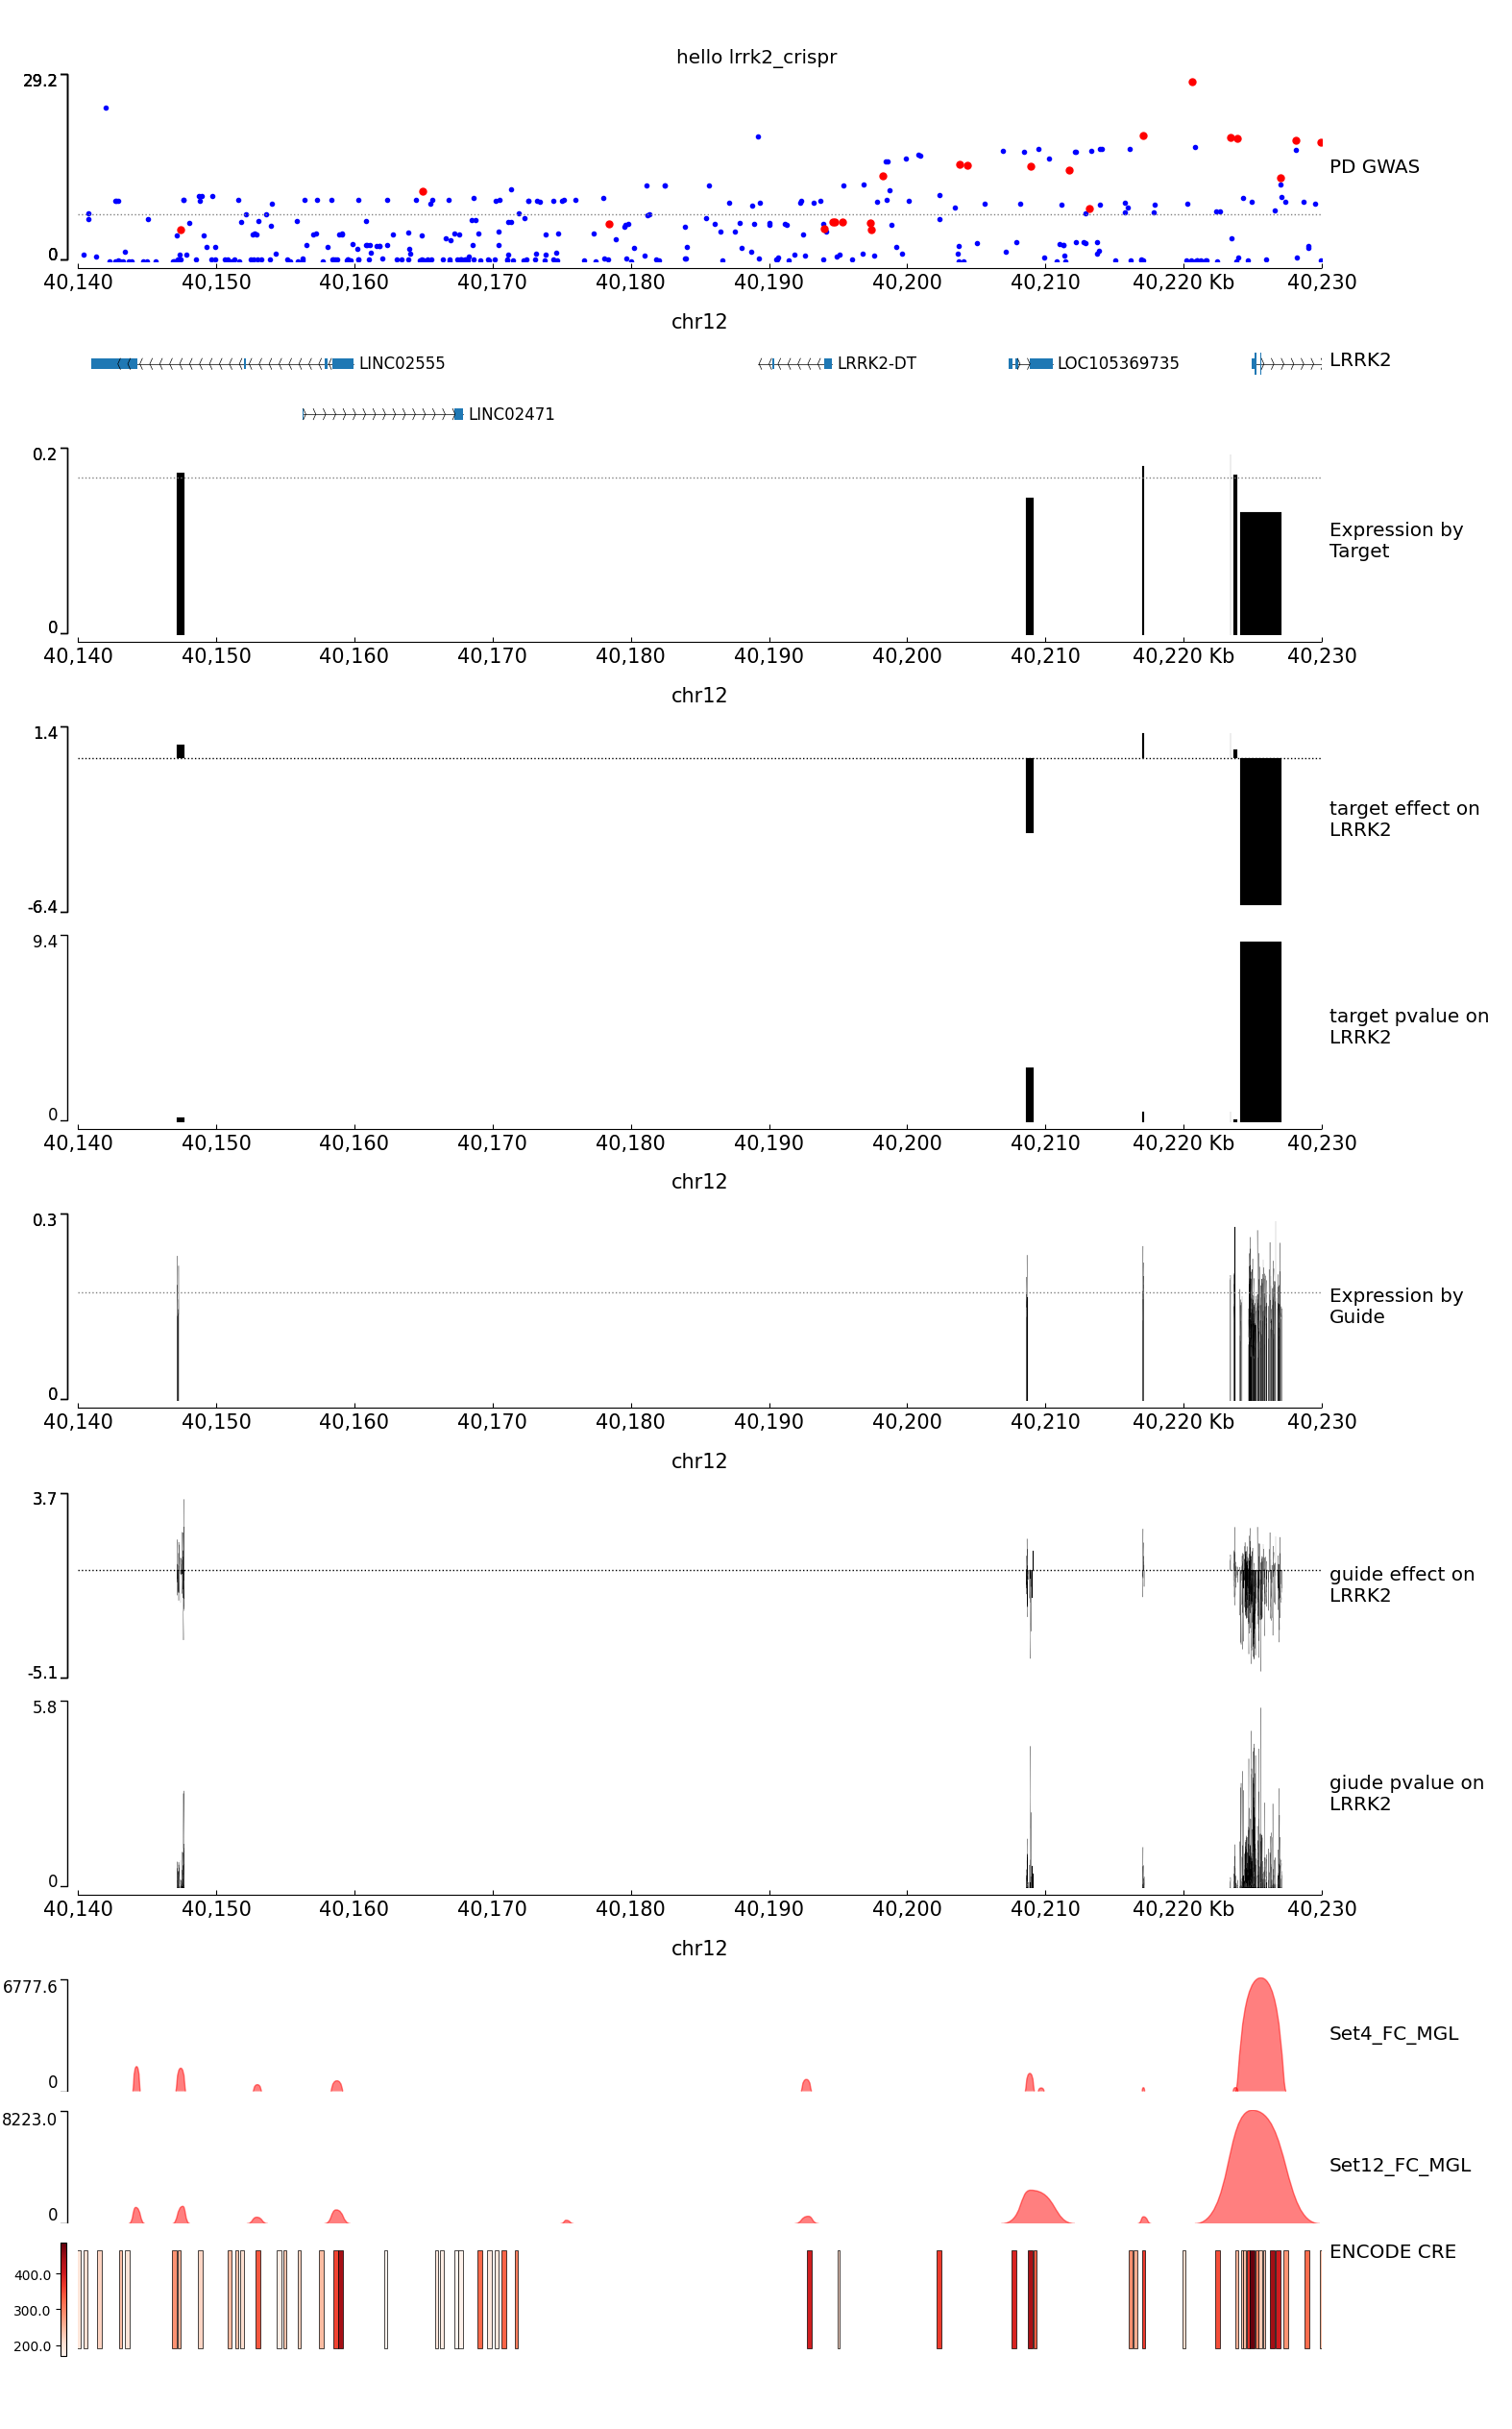

In [36]:
Image(figure_file)